In [1]:
!pip install optuna

In [2]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False,gamma=1):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = gamma # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [3]:
import numpy as np
from scipy.special import softmax

def sarsa(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using SARSA.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run SARSA for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    # initialize the state-action value function and the state counts
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))
    
    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):

        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        # for each new episode, start at the given start state
        state = int(model.start_state_seq)
        # sample first action
        action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            # initialize p and r
            p, r = 0, np.random.random()
            # sample the next state according to the action and the
            # probability of the transition
            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break
            # sample the next action
            next_action = sample_action(Q, next_state, model.num_actions, epsilon, temperature, action_strategy)
            # Calculate the temporal difference and update Q function
            Q[state, action] += alpha * (model.R[state] + model.gamma * Q[next_state, next_action] - Q[state, action])
            # End episode is state is a terminal state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

            # count the state visits
            state_counts[state] += 1

            # store the previous state and action
            state = next_state
            action = next_action

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    # determine the q function and policy
    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

def sample_action(Q, state, num_actions, epsilon, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Action selection based on the specified strategy.

    Parameters
    ----------
    Q : numpy array of shape (N, num_actions)
        Q function for the environment where N is the total number of states.

    state : int
        The current state.

    num_actions : int
        The number of actions.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    action : int
        Number representing the selected action between 0 and num_actions.
    """
    if action_strategy == 'epsilon-greedy':
        if np.random.random() < epsilon:
            action = np.random.randint(0, num_actions)
        else:
            action = np.argmax(Q[state, :])
    elif action_strategy == 'softmax':
        action_values = Q[state, :]
        probabilities = softmax(action_values / temperature)
        action = np.random.choice(np.arange(num_actions), p=probabilities)
    else:
        raise ValueError("Invalid action_strategy. Use 'epsilon-greedy' or 'softmax'.")

    return action


def qlearning(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using Q-learning.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run Q-learning for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))

    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):
        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        state = int(model.start_state_seq)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)

            p, r = 0, np.random.random()

            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break

            Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])

            state_counts[state] += 1

            state = next_state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

In [4]:
from plots import plot_gridworld

In [5]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)

env_0 = gw.create_gridworld()


In [6]:
import optuna

In [7]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    epsilon = trial.suggest_float('epsilon', 0.1, 0.5, log=True)
    g=trial.suggest_float('gamma',0.5,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Epsilon = {epsilon},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                    bias=0.5)

    env_0 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts, steps, rewards = sarsa(env_0, alpha=alpha, epsilon=epsilon, maxiter=100, maxeps=5000)
        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters


[I 2024-02-27 19:33:46,831] A new study created in memory with name: no-name-bdcd6638-f2af-472c-a8b3-c4e5c409ed63


Trial 0: Alpha = 0.18379084294718132, Epsilon = 0.13306576766505995,Gamma=0.705327505125921
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:34:25,518] Trial 0 finished with value: 359035.3 and parameters: {'alpha': 0.18379084294718132, 'epsilon': 0.13306576766505995, 'gamma': 0.705327505125921}. Best is trial 0 with value: 359035.3.


Trial 1: Alpha = 0.23992334492788278, Epsilon = 0.470224237302026,Gamma=0.6252460714502481
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:35:20,709] Trial 1 finished with value: 600674.8 and parameters: {'alpha': 0.23992334492788278, 'epsilon': 0.470224237302026, 'gamma': 0.6252460714502481}. Best is trial 0 with value: 359035.3.


Trial 2: Alpha = 0.2250630583181197, Epsilon = 0.20114754582778138,Gamma=0.7298286422992308
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:36:04,140] Trial 2 finished with value: 409699.8 and parameters: {'alpha': 0.2250630583181197, 'epsilon': 0.20114754582778138, 'gamma': 0.7298286422992308}. Best is trial 0 with value: 359035.3.


Trial 3: Alpha = 0.22153722911132373, Epsilon = 0.21835388690795213,Gamma=0.744496039889535
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:36:51,799] Trial 3 finished with value: 453008.1 and parameters: {'alpha': 0.22153722911132373, 'epsilon': 0.21835388690795213, 'gamma': 0.744496039889535}. Best is trial 0 with value: 359035.3.


Trial 4: Alpha = 0.3032439950379715, Epsilon = 0.4687753493306266,Gamma=0.7676651130673042
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:37:47,066] Trial 4 finished with value: 595747.0 and parameters: {'alpha': 0.3032439950379715, 'epsilon': 0.4687753493306266, 'gamma': 0.7676651130673042}. Best is trial 0 with value: 359035.3.


Trial 5: Alpha = 0.3192613715341729, Epsilon = 0.1653167632115602,Gamma=0.6733322016978966
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:38:39,534] Trial 5 finished with value: 495772.19999999995 and parameters: {'alpha': 0.3192613715341729, 'epsilon': 0.1653167632115602, 'gamma': 0.6733322016978966}. Best is trial 0 with value: 359035.3.


Trial 6: Alpha = 0.12821819630849304, Epsilon = 0.3178194253072248,Gamma=0.7204627259414957
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:39:33,909] Trial 6 finished with value: 536565.5 and parameters: {'alpha': 0.12821819630849304, 'epsilon': 0.3178194253072248, 'gamma': 0.7204627259414957}. Best is trial 0 with value: 359035.3.


Trial 7: Alpha = 0.42494643836651824, Epsilon = 0.192131195165428,Gamma=0.9131415325227862
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:39:57,588] Trial 7 finished with value: 250600.9 and parameters: {'alpha': 0.42494643836651824, 'epsilon': 0.192131195165428, 'gamma': 0.9131415325227862}. Best is trial 7 with value: 250600.9.


Trial 8: Alpha = 0.20940000912694834, Epsilon = 0.34105513455414976,Gamma=0.582313315311357
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:40:54,783] Trial 8 finished with value: 560724.3999999999 and parameters: {'alpha': 0.20940000912694834, 'epsilon': 0.34105513455414976, 'gamma': 0.582313315311357}. Best is trial 7 with value: 250600.9.


Trial 9: Alpha = 0.4543380620740001, Epsilon = 0.3321936325650853,Gamma=0.9511059739183603
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:41:25,366] Trial 9 finished with value: 359659.4 and parameters: {'alpha': 0.4543380620740001, 'epsilon': 0.3321936325650853, 'gamma': 0.9511059739183603}. Best is trial 7 with value: 250600.9.


Trial 10: Alpha = 0.4843865800006964, Epsilon = 0.1107334478101073,Gamma=0.9925274442543773
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:41:51,037] Trial 10 finished with value: 256874.6 and parameters: {'alpha': 0.4843865800006964, 'epsilon': 0.1107334478101073, 'gamma': 0.9925274442543773}. Best is trial 7 with value: 250600.9.


Trial 11: Alpha = 0.48345822989991283, Epsilon = 0.10337617803875371,Gamma=0.9925311614532782
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 19:42:14,295] Trial 11 finished with value: 245971.09999999998 and parameters: {'alpha': 0.48345822989991283, 'epsilon': 0.10337617803875371, 'gamma': 0.9925311614532782}. Best is trial 11 with value: 245971.09999999998.


Running episode 4000.
Trial 12: Alpha = 0.3814031523639874, Epsilon = 0.10165422725685411,Gamma=0.8714843596565065
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:42:35,171] Trial 12 finished with value: 190128.6 and parameters: {'alpha': 0.3814031523639874, 'epsilon': 0.10165422725685411, 'gamma': 0.8714843596565065}. Best is trial 12 with value: 190128.6.


Trial 13: Alpha = 0.35540032813134514, Epsilon = 0.1091454085967584,Gamma=0.8539899235375435
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:42:55,720] Trial 13 finished with value: 190901.5 and parameters: {'alpha': 0.35540032813134514, 'epsilon': 0.1091454085967584, 'gamma': 0.8539899235375435}. Best is trial 12 with value: 190128.6.


Trial 14: Alpha = 0.3473919312197539, Epsilon = 0.13176412730504622,Gamma=0.8649084179447322
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:43:17,067] Trial 14 finished with value: 203283.40000000002 and parameters: {'alpha': 0.3473919312197539, 'epsilon': 0.13176412730504622, 'gamma': 0.8649084179447322}. Best is trial 12 with value: 190128.6.


Trial 15: Alpha = 0.36617963095411604, Epsilon = 0.14094398737297587,Gamma=0.5011839415074616
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:44:12,625] Trial 15 finished with value: 515025.8 and parameters: {'alpha': 0.36617963095411604, 'epsilon': 0.14094398737297587, 'gamma': 0.5011839415074616}. Best is trial 12 with value: 190128.6.


Trial 16: Alpha = 0.276342033380861, Epsilon = 0.1026632269915412,Gamma=0.8364573891163753
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:44:36,019] Trial 16 finished with value: 216620.2 and parameters: {'alpha': 0.276342033380861, 'epsilon': 0.1026632269915412, 'gamma': 0.8364573891163753}. Best is trial 12 with value: 190128.6.


Trial 17: Alpha = 0.10208409968314716, Epsilon = 0.2680904167037966,Gamma=0.8316114660416697
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:45:00,808] Trial 17 finished with value: 264039.0 and parameters: {'alpha': 0.10208409968314716, 'epsilon': 0.2680904167037966, 'gamma': 0.8316114660416697}. Best is trial 12 with value: 190128.6.


Trial 18: Alpha = 0.3908708968444801, Epsilon = 0.15552809215640176,Gamma=0.8051464701951618
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:45:33,888] Trial 18 finished with value: 324146.3 and parameters: {'alpha': 0.3908708968444801, 'epsilon': 0.15552809215640176, 'gamma': 0.8051464701951618}. Best is trial 12 with value: 190128.6.


Trial 19: Alpha = 0.16514667739018538, Epsilon = 0.11997205307485435,Gamma=0.8888806465190809
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 19:45:53,167] Trial 19 finished with value: 180699.1 and parameters: {'alpha': 0.16514667739018538, 'epsilon': 0.11997205307485435, 'gamma': 0.8888806465190809}. Best is trial 19 with value: 180699.1.


Running episode 4000.


In [8]:

best_alpha = study.best_params['alpha']
best_epsilon = study.best_params['epsilon']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best Epsilon:", best_epsilon)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.16514667739018538
Best Epsilon: 0.11997205307485435
Best gamma: 0.8888806465190809


In [9]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)

env_0 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_0, alpha=best_alpha, epsilon=best_epsilon, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [10]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


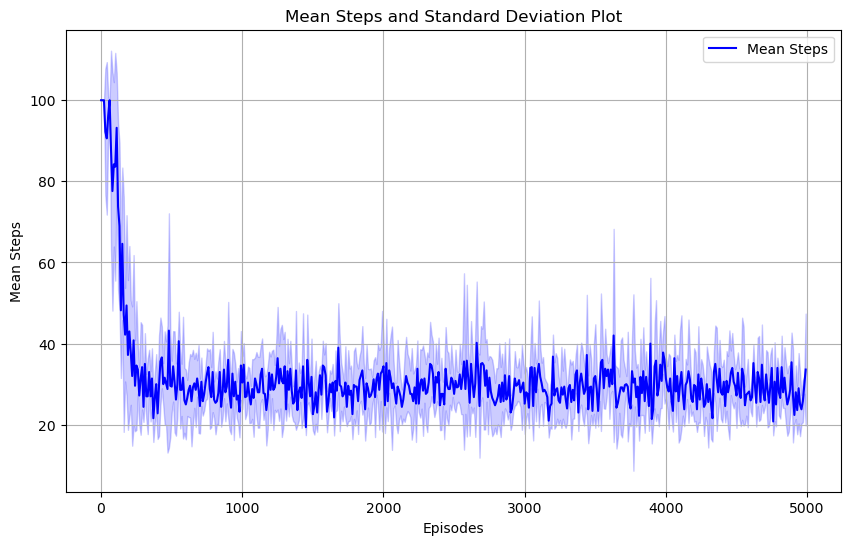

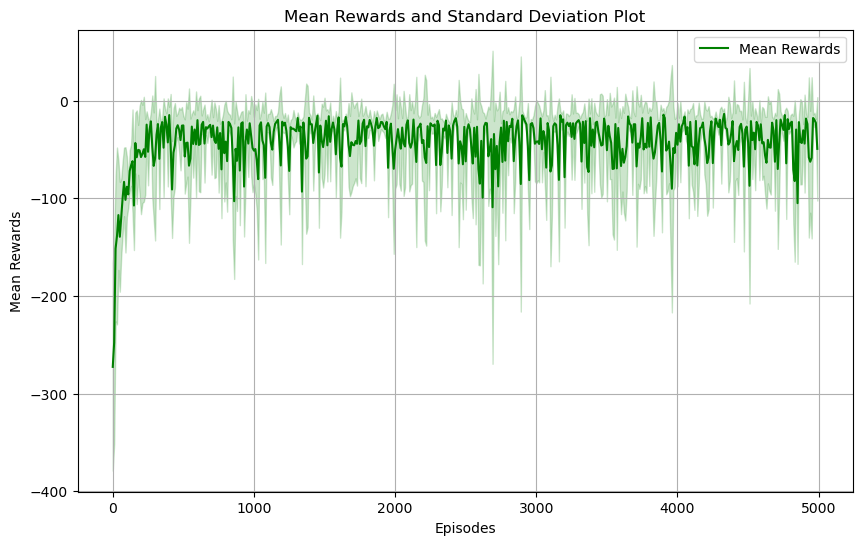

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


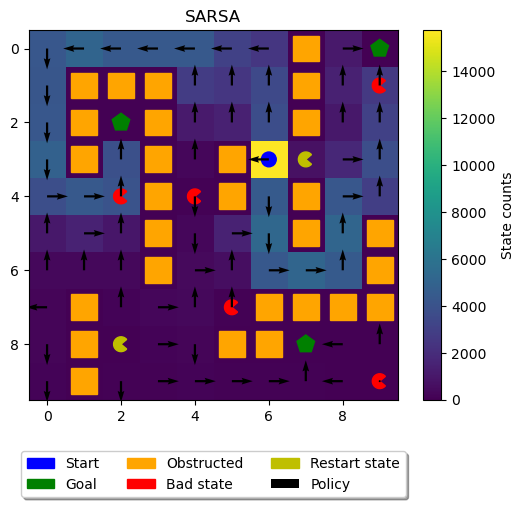

In [12]:
plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="SARSA")

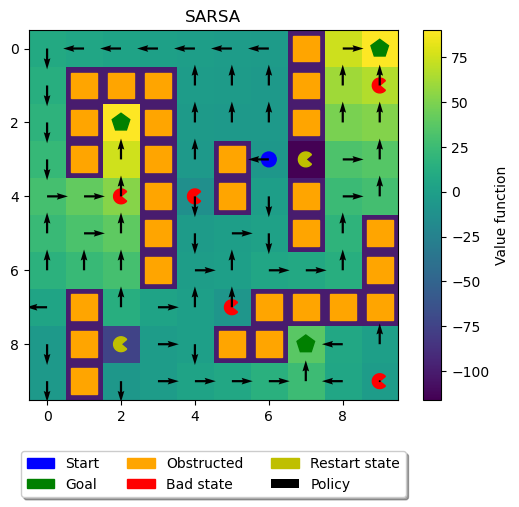

In [13]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="SARSA")

In [14]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    temp = trial.suggest_float('temperature',0.1,1, log=True)
    g=trial.suggest_float('gamma',0.5,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Temperature = {temp},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                    bias=0.5)

    env_0 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts,steps,rewards = sarsa(env_0, alpha=alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=temp)

        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters


[I 2024-02-27 19:46:12,731] A new study created in memory with name: no-name-c487742d-4a0a-4d8f-9e63-9998c7f7c6d4


Trial 0: Alpha = 0.14998576434021127, Temperature = 0.25982297162129736,Gamma=0.5503661188999751
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:48:04,463] Trial 0 finished with value: 437646.5 and parameters: {'alpha': 0.14998576434021127, 'temperature': 0.25982297162129736, 'gamma': 0.5503661188999751}. Best is trial 0 with value: 437646.5.


Trial 1: Alpha = 0.3322430204169262, Temperature = 0.1548597597310024,Gamma=0.9943511281714379
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:48:47,506] Trial 1 finished with value: 137386.2 and parameters: {'alpha': 0.3322430204169262, 'temperature': 0.1548597597310024, 'gamma': 0.9943511281714379}. Best is trial 1 with value: 137386.2.


Trial 2: Alpha = 0.4116329023457526, Temperature = 0.6523560713338971,Gamma=0.8991197200742538
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:49:27,250] Trial 2 finished with value: 133181.5 and parameters: {'alpha': 0.4116329023457526, 'temperature': 0.6523560713338971, 'gamma': 0.8991197200742538}. Best is trial 2 with value: 133181.5.


Trial 3: Alpha = 0.2532630891018257, Temperature = 0.13985114120350642,Gamma=0.797024619723151
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:50:08,929] Trial 3 finished with value: 147130.40000000002 and parameters: {'alpha': 0.2532630891018257, 'temperature': 0.13985114120350642, 'gamma': 0.797024619723151}. Best is trial 2 with value: 133181.5.


Trial 4: Alpha = 0.13129161909642584, Temperature = 0.40532660910429497,Gamma=0.5768411621714841
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:52:00,219] Trial 4 finished with value: 439113.69999999995 and parameters: {'alpha': 0.13129161909642584, 'temperature': 0.40532660910429497, 'gamma': 0.5768411621714841}. Best is trial 2 with value: 133181.5.


Trial 5: Alpha = 0.22324460652609945, Temperature = 0.1109677021217693,Gamma=0.7185607669120436
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:53:15,093] Trial 5 finished with value: 285354.19999999995 and parameters: {'alpha': 0.22324460652609945, 'temperature': 0.1109677021217693, 'gamma': 0.7185607669120436}. Best is trial 2 with value: 133181.5.


Trial 6: Alpha = 0.1244595184591776, Temperature = 0.120496879465864,Gamma=0.6140988338662692
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:54:56,869] Trial 6 finished with value: 399701.2 and parameters: {'alpha': 0.1244595184591776, 'temperature': 0.120496879465864, 'gamma': 0.6140988338662692}. Best is trial 2 with value: 133181.5.


Trial 7: Alpha = 0.21138009859706314, Temperature = 0.8960128635637074,Gamma=0.618530948552641
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:56:48,137] Trial 7 finished with value: 443938.2 and parameters: {'alpha': 0.21138009859706314, 'temperature': 0.8960128635637074, 'gamma': 0.618530948552641}. Best is trial 2 with value: 133181.5.


Trial 8: Alpha = 0.3448495151124444, Temperature = 0.31022761859624987,Gamma=0.7753252374614351
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:57:55,534] Trial 8 finished with value: 252539.0 and parameters: {'alpha': 0.3448495151124444, 'temperature': 0.31022761859624987, 'gamma': 0.7753252374614351}. Best is trial 2 with value: 133181.5.


Trial 9: Alpha = 0.11282071281938919, Temperature = 0.7082787477817659,Gamma=0.8589947080118382
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:58:43,512] Trial 9 finished with value: 172953.8 and parameters: {'alpha': 0.11282071281938919, 'temperature': 0.7082787477817659, 'gamma': 0.8589947080118382}. Best is trial 2 with value: 133181.5.


Trial 10: Alpha = 0.4642284556035123, Temperature = 0.5272970620588913,Gamma=0.9415643403871181
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:59:25,129] Trial 10 finished with value: 136728.9 and parameters: {'alpha': 0.4642284556035123, 'temperature': 0.5272970620588913, 'gamma': 0.9415643403871181}. Best is trial 2 with value: 133181.5.


Trial 11: Alpha = 0.4664887461779028, Temperature = 0.5447596556465414,Gamma=0.9661129728186536
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:00:03,113] Trial 11 finished with value: 131985.0 and parameters: {'alpha': 0.4664887461779028, 'temperature': 0.5447596556465414, 'gamma': 0.9661129728186536}. Best is trial 11 with value: 131985.0.


Trial 12: Alpha = 0.479814137254647, Temperature = 0.5906791877753984,Gamma=0.8883049109837488
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:00:42,689] Trial 12 finished with value: 135425.7 and parameters: {'alpha': 0.479814137254647, 'temperature': 0.5906791877753984, 'gamma': 0.8883049109837488}. Best is trial 11 with value: 131985.0.


Trial 13: Alpha = 0.3709467041148604, Temperature = 0.9563262321176753,Gamma=0.8614991241230142
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:01:27,571] Trial 13 finished with value: 155477.5 and parameters: {'alpha': 0.3709467041148604, 'temperature': 0.9563262321176753, 'gamma': 0.8614991241230142}. Best is trial 11 with value: 131985.0.


Trial 14: Alpha = 0.28292965381361534, Temperature = 0.4539144842430621,Gamma=0.9885965984236331
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:02:07,987] Trial 14 finished with value: 128625.40000000001 and parameters: {'alpha': 0.28292965381361534, 'temperature': 0.4539144842430621, 'gamma': 0.9885965984236331}. Best is trial 14 with value: 128625.40000000001.


Trial 15: Alpha = 0.2946157312079391, Temperature = 0.21812007816957657,Gamma=0.9769748497315658
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:02:46,163] Trial 15 finished with value: 127701.8 and parameters: {'alpha': 0.2946157312079391, 'temperature': 0.21812007816957657, 'gamma': 0.9769748497315658}. Best is trial 15 with value: 127701.8.


Trial 16: Alpha = 0.2728188801568502, Temperature = 0.19579750641027657,Gamma=0.5037173238520279
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:04:40,710] Trial 16 finished with value: 445760.8 and parameters: {'alpha': 0.2728188801568502, 'temperature': 0.19579750641027657, 'gamma': 0.5037173238520279}. Best is trial 15 with value: 127701.8.


Trial 17: Alpha = 0.18633724519840836, Temperature = 0.4107273073034491,Gamma=0.7813780717822747
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:05:51,144] Trial 17 finished with value: 262399.5 and parameters: {'alpha': 0.18633724519840836, 'temperature': 0.4107273073034491, 'gamma': 0.7813780717822747}. Best is trial 15 with value: 127701.8.


Trial 18: Alpha = 0.28882619631045786, Temperature = 0.20899773270576713,Gamma=0.7094002242691128
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:07:19,700] Trial 18 finished with value: 340728.9 and parameters: {'alpha': 0.28882619631045786, 'temperature': 0.20899773270576713, 'gamma': 0.7094002242691128}. Best is trial 15 with value: 127701.8.


Trial 19: Alpha = 0.1775064900567603, Temperature = 0.4022678269212217,Gamma=0.6591510603117972
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:09:01,485] Trial 19 finished with value: 400609.2 and parameters: {'alpha': 0.1775064900567603, 'temperature': 0.4022678269212217, 'gamma': 0.6591510603117972}. Best is trial 15 with value: 127701.8.


In [15]:

best_alpha = study.best_params['alpha']
best_temp = study.best_params['temperature']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best temp:", best_temp)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.2946157312079391
Best temp: 0.21812007816957657
Best gamma: 0.9769748497315658


In [16]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)

env_0 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_0, alpha=best_alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=best_temp)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [17]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


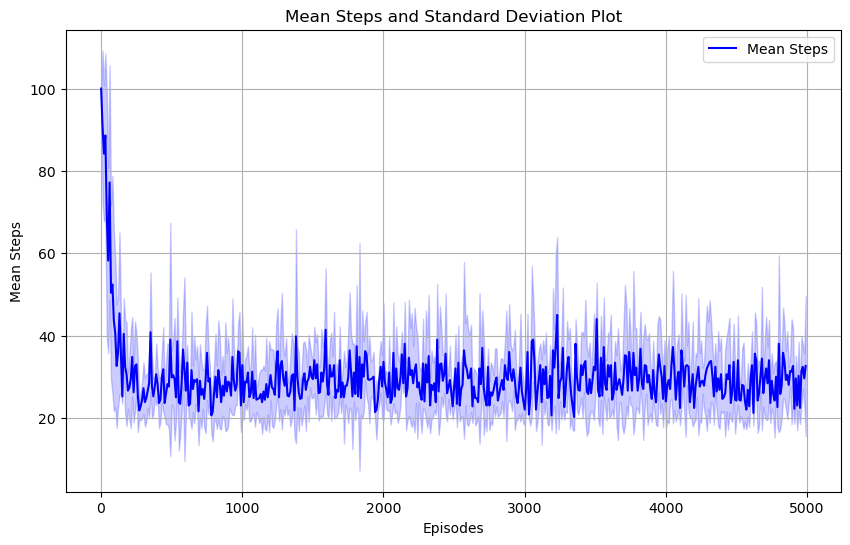

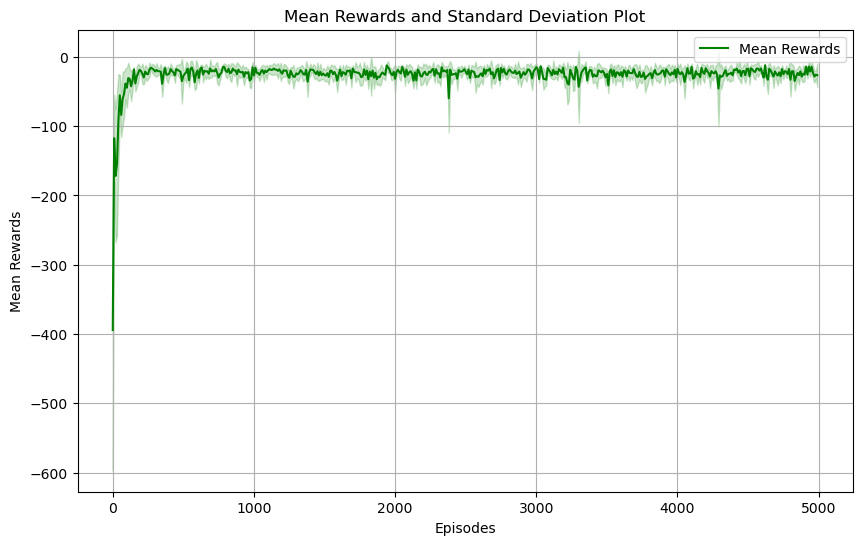

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


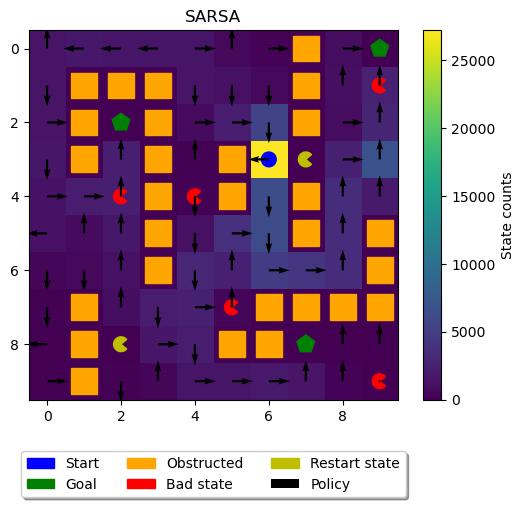

In [19]:

plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="SARSA")

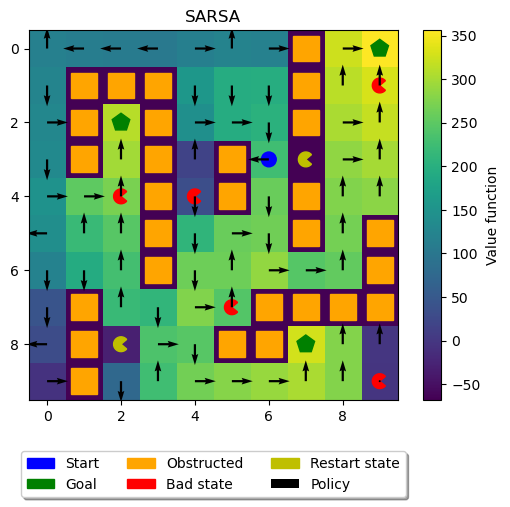

In [20]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="SARSA")

In [21]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)

env_1 = gw.create_gridworld()


In [22]:

def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    epsilon = trial.suggest_float('epsilon', 0.1, 0.5, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Epsilon = {epsilon},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)

    env_1 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts, steps, rewards = sarsa(env_1, alpha=alpha, epsilon=epsilon, maxiter=100, maxeps=5000)
        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials



[I 2024-02-27 20:09:44,021] A new study created in memory with name: no-name-a42ab400-e239-4820-b3fc-4b5841e1bc21


Trial 0: Alpha = 0.11905961953533131, Epsilon = 0.4482123689433345,Gamma=0.8157718049946797
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 20:10:07,524] Trial 0 finished with value: 225682.2 and parameters: {'alpha': 0.11905961953533131, 'epsilon': 0.4482123689433345, 'gamma': 0.8157718049946797}. Best is trial 0 with value: 225682.2.


Running episode 4000.
Trial 1: Alpha = 0.4508767820848802, Epsilon = 0.30720292220354334,Gamma=0.9439035070140648
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.


[I 2024-02-27 20:10:34,608] Trial 1 finished with value: 252539.0 and parameters: {'alpha': 0.4508767820848802, 'epsilon': 0.30720292220354334, 'gamma': 0.9439035070140648}. Best is trial 0 with value: 225682.2.


Running episode 3000.
Running episode 4000.
Trial 2: Alpha = 0.10801042658478044, Epsilon = 0.3772193801549674,Gamma=0.9089283061054163
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:10:55,601] Trial 2 finished with value: 195795.7 and parameters: {'alpha': 0.10801042658478044, 'epsilon': 0.3772193801549674, 'gamma': 0.9089283061054163}. Best is trial 2 with value: 195795.7.


Trial 3: Alpha = 0.14430080497389708, Epsilon = 0.20651469177784545,Gamma=0.9607219619201296
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:11:12,292] Trial 3 finished with value: 149579.09999999998 and parameters: {'alpha': 0.14430080497389708, 'epsilon': 0.20651469177784545, 'gamma': 0.9607219619201296}. Best is trial 3 with value: 149579.09999999998.


Trial 4: Alpha = 0.21786801100469722, Epsilon = 0.12894720465342005,Gamma=0.8577940850468587
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:11:29,635] Trial 4 finished with value: 151279.0 and parameters: {'alpha': 0.21786801100469722, 'epsilon': 0.12894720465342005, 'gamma': 0.8577940850468587}. Best is trial 3 with value: 149579.09999999998.


Trial 5: Alpha = 0.17535655349665413, Epsilon = 0.14356682790342395,Gamma=0.813220622482314
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.


[I 2024-02-27 20:11:46,070] Trial 5 finished with value: 143539.6 and parameters: {'alpha': 0.17535655349665413, 'epsilon': 0.14356682790342395, 'gamma': 0.813220622482314}. Best is trial 5 with value: 143539.6.


Running episode 3000.
Running episode 4000.
Trial 6: Alpha = 0.2303769805600855, Epsilon = 0.20339648523356027,Gamma=0.8515583960839179
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 20:12:04,781] Trial 6 finished with value: 165983.0 and parameters: {'alpha': 0.2303769805600855, 'epsilon': 0.20339648523356027, 'gamma': 0.8515583960839179}. Best is trial 5 with value: 143539.6.


Running episode 4000.
Trial 7: Alpha = 0.1596899738519754, Epsilon = 0.18718551005259831,Gamma=0.8056754741340817
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 20:12:21,825] Trial 7 finished with value: 149651.90000000002 and parameters: {'alpha': 0.1596899738519754, 'epsilon': 0.18718551005259831, 'gamma': 0.8056754741340817}. Best is trial 5 with value: 143539.6.


Running episode 4000.
Trial 8: Alpha = 0.15515855036545134, Epsilon = 0.29273057126025437,Gamma=0.8334711517119177
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 20:12:40,789] Trial 8 finished with value: 172980.59999999998 and parameters: {'alpha': 0.15515855036545134, 'epsilon': 0.29273057126025437, 'gamma': 0.8334711517119177}. Best is trial 5 with value: 143539.6.


Running episode 4000.
Trial 9: Alpha = 0.11089762510577866, Epsilon = 0.42661990549567586,Gamma=0.9284550274856704
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:13:03,630] Trial 9 finished with value: 215552.0 and parameters: {'alpha': 0.11089762510577866, 'epsilon': 0.42661990549567586, 'gamma': 0.9284550274856704}. Best is trial 5 with value: 143539.6.


Trial 10: Alpha = 0.3120393107939551, Epsilon = 0.12471975470946929,Gamma=0.9942577648267763
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 20:13:23,355] Trial 10 finished with value: 174522.5 and parameters: {'alpha': 0.3120393107939551, 'epsilon': 0.12471975470946929, 'gamma': 0.9942577648267763}. Best is trial 5 with value: 143539.6.


Running episode 4000.
Trial 11: Alpha = 0.16608118544356198, Epsilon = 0.16039163276320897,Gamma=0.9815240006028573
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:13:39,989] Trial 11 finished with value: 146048.2 and parameters: {'alpha': 0.16608118544356198, 'epsilon': 0.16039163276320897, 'gamma': 0.9815240006028573}. Best is trial 5 with value: 143539.6.


Trial 12: Alpha = 0.20669127039117555, Epsilon = 0.10157921235000181,Gamma=0.8770907481702775
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:13:57,007] Trial 12 finished with value: 146887.3 and parameters: {'alpha': 0.20669127039117555, 'epsilon': 0.10157921235000181, 'gamma': 0.8770907481702775}. Best is trial 5 with value: 143539.6.


Trial 13: Alpha = 0.28535075647436, Epsilon = 0.1530949070755108,Gamma=0.998002766748775
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:14:16,388] Trial 13 finished with value: 170304.4 and parameters: {'alpha': 0.28535075647436, 'epsilon': 0.1530949070755108, 'gamma': 0.998002766748775}. Best is trial 5 with value: 143539.6.


Trial 14: Alpha = 0.17116034656634746, Epsilon = 0.15419708209434507,Gamma=0.8918587500549929
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:14:33,233] Trial 14 finished with value: 146599.3 and parameters: {'alpha': 0.17116034656634746, 'epsilon': 0.15419708209434507, 'gamma': 0.8918587500549929}. Best is trial 5 with value: 143539.6.


Trial 15: Alpha = 0.19212153466129614, Epsilon = 0.2502124404865533,Gamma=0.9575225152159664
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:14:51,520] Trial 15 finished with value: 164698.4 and parameters: {'alpha': 0.19212153466129614, 'epsilon': 0.2502124404865533, 'gamma': 0.9575225152159664}. Best is trial 5 with value: 143539.6.


Trial 16: Alpha = 0.2770618718578415, Epsilon = 0.16598530506908024,Gamma=0.9211364212967292
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:15:10,510] Trial 16 finished with value: 167488.6 and parameters: {'alpha': 0.2770618718578415, 'epsilon': 0.16598530506908024, 'gamma': 0.9211364212967292}. Best is trial 5 with value: 143539.6.


Trial 17: Alpha = 0.13284265584118657, Epsilon = 0.10591409105692474,Gamma=0.8676125902771497
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:15:25,429] Trial 17 finished with value: 128948.9 and parameters: {'alpha': 0.13284265584118657, 'epsilon': 0.10591409105692474, 'gamma': 0.8676125902771497}. Best is trial 17 with value: 128948.9.


Trial 18: Alpha = 0.13030987896683902, Epsilon = 0.10103232706645177,Gamma=0.8340531141564259
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:15:40,165] Trial 18 finished with value: 127754.2 and parameters: {'alpha': 0.13030987896683902, 'epsilon': 0.10103232706645177, 'gamma': 0.8340531141564259}. Best is trial 18 with value: 127754.2.


Trial 19: Alpha = 0.13349442376761853, Epsilon = 0.11187131718738864,Gamma=0.8653521261910396
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:15:55,367] Trial 19 finished with value: 132173.4 and parameters: {'alpha': 0.13349442376761853, 'epsilon': 0.11187131718738864, 'gamma': 0.8653521261910396}. Best is trial 18 with value: 127754.2.


In [23]:


# Get the best hyperparameters


best_alpha = study.best_params['alpha']
best_epsilon = study.best_params['epsilon']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best Epsilon:", best_epsilon)
print("Best gamma:", best_gamma)




Best Hyperparameters:
Best Alpha: 0.13030987896683902
Best Epsilon: 0.10103232706645177
Best gamma: 0.8340531141564259


In [24]:


num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)

env_1 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_1, alpha=best_alpha, epsilon=best_epsilon, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)


Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [25]:

avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


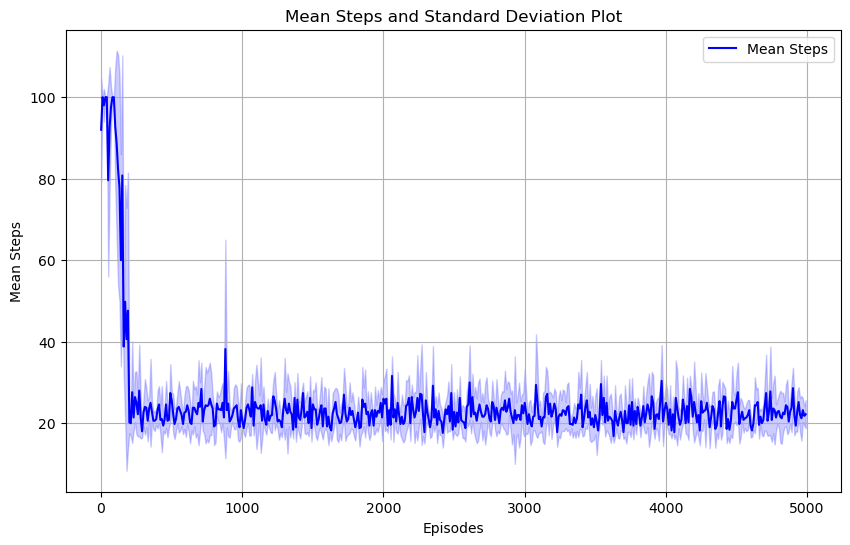

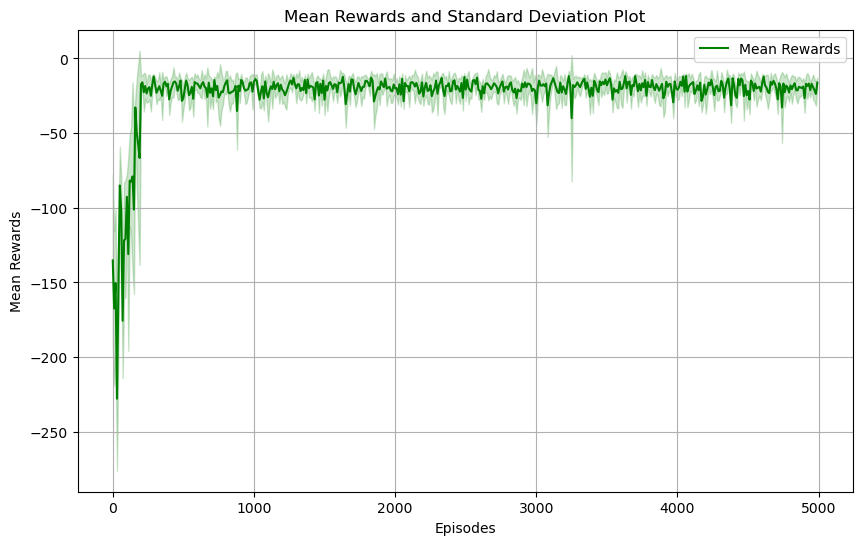

In [26]:


import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


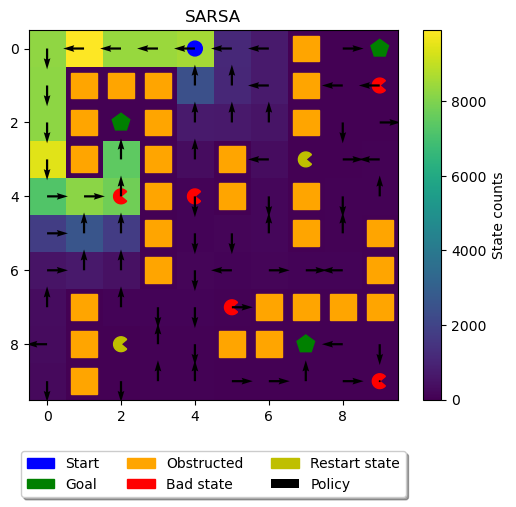

In [27]:


plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="SARSA")


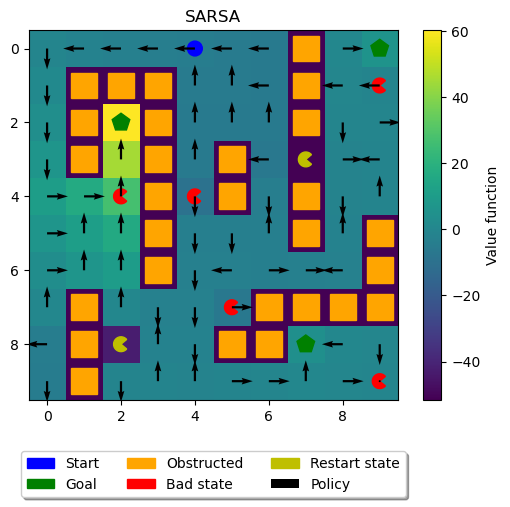

In [28]:


plot_gridworld(env_1, policy=pi,value_function=avg_q, title="SARSA")


In [29]:

def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    temp = trial.suggest_float('temperature',0.1,1, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Temperature = {temp},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                    bias=0.5)

    env_1 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts,steps,rewards = sarsa(env_1, alpha=alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=temp)

        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials


[I 2024-02-27 20:16:09,789] A new study created in memory with name: no-name-5cf826ba-ed3a-477f-8e81-4df404853244


Trial 0: Alpha = 0.23084363461250895, Temperature = 0.9013599015430769,Gamma=0.9259800595553451
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:16:39,806] Trial 0 finished with value: 111060.0 and parameters: {'alpha': 0.23084363461250895, 'temperature': 0.9013599015430769, 'gamma': 0.9259800595553451}. Best is trial 0 with value: 111060.0.


Trial 1: Alpha = 0.13156546790217802, Temperature = 0.7349473362408829,Gamma=0.852993893030327
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:17:18,848] Trial 1 finished with value: 150352.5 and parameters: {'alpha': 0.13156546790217802, 'temperature': 0.7349473362408829, 'gamma': 0.852993893030327}. Best is trial 0 with value: 111060.0.


Trial 2: Alpha = 0.30267367486393765, Temperature = 0.1149546971018133,Gamma=0.933305325914992
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:17:48,044] Trial 2 finished with value: 104091.3 and parameters: {'alpha': 0.30267367486393765, 'temperature': 0.1149546971018133, 'gamma': 0.933305325914992}. Best is trial 2 with value: 104091.3.


Trial 3: Alpha = 0.15971300311443062, Temperature = 0.6401362191868976,Gamma=0.9739414664993031
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:18:18,814] Trial 3 finished with value: 112728.0 and parameters: {'alpha': 0.15971300311443062, 'temperature': 0.6401362191868976, 'gamma': 0.9739414664993031}. Best is trial 2 with value: 104091.3.


Trial 4: Alpha = 0.3913196641720208, Temperature = 0.13133267090106704,Gamma=0.8083210897525236
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:18:50,743] Trial 4 finished with value: 117150.5 and parameters: {'alpha': 0.3913196641720208, 'temperature': 0.13133267090106704, 'gamma': 0.8083210897525236}. Best is trial 2 with value: 104091.3.


Trial 5: Alpha = 0.12015590123176398, Temperature = 0.5852861096166035,Gamma=0.804865674159206
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:20:03,084] Trial 5 finished with value: 290008.8 and parameters: {'alpha': 0.12015590123176398, 'temperature': 0.5852861096166035, 'gamma': 0.804865674159206}. Best is trial 2 with value: 104091.3.


Trial 6: Alpha = 0.23995317579103465, Temperature = 0.9107529519308701,Gamma=0.8831152175576906
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:20:34,425] Trial 6 finished with value: 116615.4 and parameters: {'alpha': 0.23995317579103465, 'temperature': 0.9107529519308701, 'gamma': 0.8831152175576906}. Best is trial 2 with value: 104091.3.


Trial 7: Alpha = 0.3895558327624949, Temperature = 0.2052862861742251,Gamma=0.8033351355981161
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:21:19,325] Trial 7 finished with value: 169481.0 and parameters: {'alpha': 0.3895558327624949, 'temperature': 0.2052862861742251, 'gamma': 0.8033351355981161}. Best is trial 2 with value: 104091.3.


Trial 8: Alpha = 0.17114538612899907, Temperature = 0.22399161094192352,Gamma=0.8201151613291119
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:21:53,201] Trial 8 finished with value: 127355.3 and parameters: {'alpha': 0.17114538612899907, 'temperature': 0.22399161094192352, 'gamma': 0.8201151613291119}. Best is trial 2 with value: 104091.3.


Trial 9: Alpha = 0.13113338245712755, Temperature = 0.16969183061898804,Gamma=0.8653889109977185
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:22:22,471] Trial 9 finished with value: 108563.2 and parameters: {'alpha': 0.13113338245712755, 'temperature': 0.16969183061898804, 'gamma': 0.8653889109977185}. Best is trial 2 with value: 104091.3.


Trial 10: Alpha = 0.3138064084657087, Temperature = 0.1121753607552811,Gamma=0.9348195183105668
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:22:52,850] Trial 10 finished with value: 114589.3 and parameters: {'alpha': 0.3138064084657087, 'temperature': 0.1121753607552811, 'gamma': 0.9348195183105668}. Best is trial 2 with value: 104091.3.


Trial 11: Alpha = 0.10270795472320605, Temperature = 0.1645369696552985,Gamma=0.8815968180081917
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:23:23,085] Trial 11 finished with value: 111473.9 and parameters: {'alpha': 0.10270795472320605, 'temperature': 0.1645369696552985, 'gamma': 0.8815968180081917}. Best is trial 2 with value: 104091.3.


Trial 12: Alpha = 0.2936366801092115, Temperature = 0.3238299085929319,Gamma=0.9254896893873811
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:23:52,604] Trial 12 finished with value: 107728.1 and parameters: {'alpha': 0.2936366801092115, 'temperature': 0.3238299085929319, 'gamma': 0.9254896893873811}. Best is trial 2 with value: 104091.3.


Trial 13: Alpha = 0.4966301980046106, Temperature = 0.3910752306010361,Gamma=0.9270608805045019
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:24:29,767] Trial 13 finished with value: 134238.1 and parameters: {'alpha': 0.4966301980046106, 'temperature': 0.3910752306010361, 'gamma': 0.9270608805045019}. Best is trial 2 with value: 104091.3.


Trial 14: Alpha = 0.28941665414213646, Temperature = 0.3312717178164408,Gamma=0.9755053516741921
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:24:57,914] Trial 14 finished with value: 101635.7 and parameters: {'alpha': 0.28941665414213646, 'temperature': 0.3312717178164408, 'gamma': 0.9755053516741921}. Best is trial 14 with value: 101635.7.


Trial 15: Alpha = 0.29509809146686244, Temperature = 0.43278874424176234,Gamma=0.9924976759018193
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:25:30,434] Trial 15 finished with value: 119625.9 and parameters: {'alpha': 0.29509809146686244, 'temperature': 0.43278874424176234, 'gamma': 0.9924976759018193}. Best is trial 14 with value: 101635.7.


Trial 16: Alpha = 0.18489616015981417, Temperature = 0.2643762832094666,Gamma=0.9593164751933275
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:26:03,102] Trial 16 finished with value: 119347.20000000001 and parameters: {'alpha': 0.18489616015981417, 'temperature': 0.2643762832094666, 'gamma': 0.9593164751933275}. Best is trial 14 with value: 101635.7.


Trial 17: Alpha = 0.36002984005009264, Temperature = 0.4686567414289578,Gamma=0.9901150525986633
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:26:33,949] Trial 17 finished with value: 110309.5 and parameters: {'alpha': 0.36002984005009264, 'temperature': 0.4686567414289578, 'gamma': 0.9901150525986633}. Best is trial 14 with value: 101635.7.


Trial 18: Alpha = 0.49413919766078174, Temperature = 0.3015639569247121,Gamma=0.9549652900244013
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:27:04,108] Trial 18 finished with value: 108277.4 and parameters: {'alpha': 0.49413919766078174, 'temperature': 0.3015639569247121, 'gamma': 0.9549652900244013}. Best is trial 14 with value: 101635.7.


Trial 19: Alpha = 0.20948976257155633, Temperature = 0.11112139257866707,Gamma=0.9104624737353095
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 20:27:33,121] Trial 19 finished with value: 105699.7 and parameters: {'alpha': 0.20948976257155633, 'temperature': 0.11112139257866707, 'gamma': 0.9104624737353095}. Best is trial 14 with value: 101635.7.


In [30]:


# Get the best hyperparameters


best_alpha = study.best_params['alpha']
best_temp = study.best_params['temperature']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best temp:", best_temp)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.28941665414213646
Best temp: 0.3312717178164408
Best gamma: 0.9755053516741921


In [37]:


num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)

env_1 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_1, alpha=best_alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=best_temp)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)


Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [38]:

avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


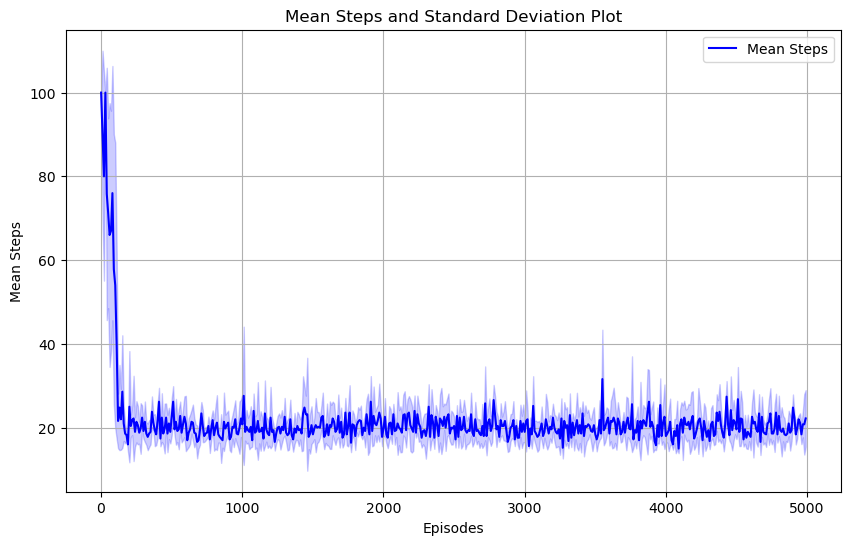

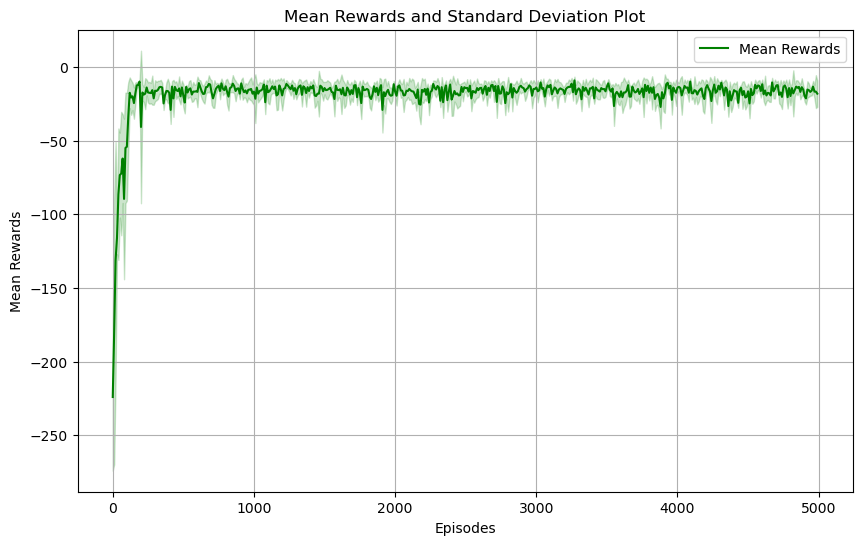

In [39]:


import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


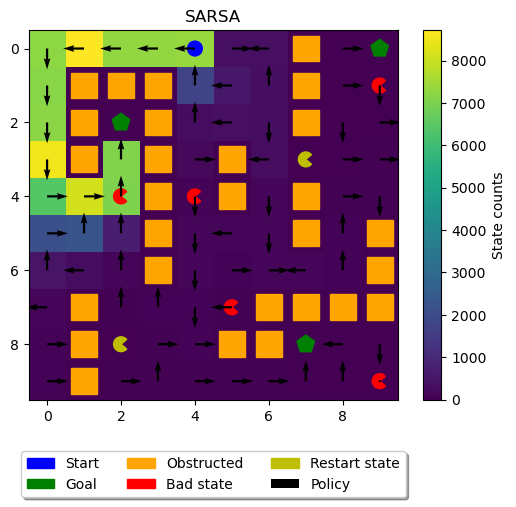

In [40]:



plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="SARSA")


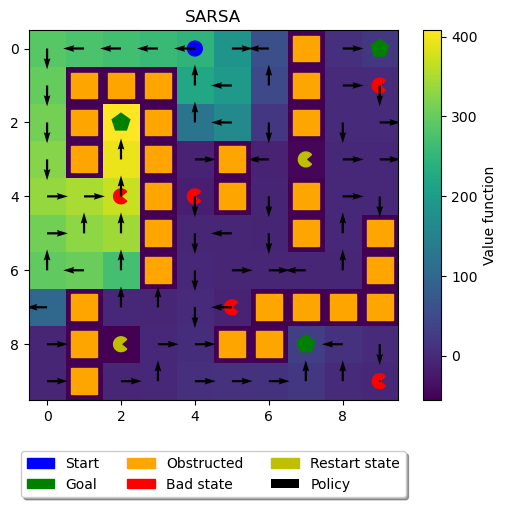

In [41]:


plot_gridworld(env_1, policy=pi,value_function=avg_q, title="SARSA")